#*1st Online Workshop: AI & Applications (AI & Agriculutre Session)*


---


## **🌴🌰** Date Fruit Shape Recognition AI App

This notebook is designed for date fruit shape recognition using image processing techniques and deep learning. It includes the following steps:

*  **Preprocessing:** Convert images to grayscale, apply noise reduction, and perform edge detection.
*  **Feature Extraction:** Identify shape characteristics like roundness, elongation, and contours.
*  **Classification**: Use a DenseNet-based transfer learning model to classify different shapes of date fruits.
* **Evaluation**
* **Deployement**








   
    



## Mount to the drive account to load the dataset 📌

In [ ]:
# prompt: mount to drive

from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


## Import the necessary librairies 💡

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import pickle



## Load the dataset from the drive path 📃

In [ ]:
dataset_dir = '/content/drive/MyDrive/DateFruitsShapeDataset'

## Image Preprocessing (Edge Detection & Shape Analysis) ⚛

📌 Description:

  * Each image is converted to grayscale for better edge detection.
  * Gaussian blur is applied to reduce noise in the images.
  * Canny edge detection is used to highlight the shapes and contours of the date fruits.

In [ ]:
subdirs = [subdir for subdir in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, subdir))]

# Iterate over each subdirectory
for subdir in subdirs:
    subdir_path = os.path.join(dataset_dir, subdir)

    # Get a list of all image file paths in the subdirectory
    image_paths = [os.path.join(subdir_path, file) for file in os.listdir(subdir_path) if file.endswith('.PNG')]

    # Iterate over each image in the subdirectory
    for image_path in image_paths:
        # Load the image
        img = cv2.imread(image_path)

        # Convert the image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Apply Gaussian blur to reduce noise
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)

        # Apply Canny edge detection
        edges = cv2.Canny(blurred, 50, 150)

        # Display the original image and the edge map
        plt.figure()
        plt.subplot(121), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title('Original Image'), plt.xticks([]), plt.yticks([])
        plt.subplot(122), plt.imshow(edges, cmap='gray')
        plt.title('Edge Map'), plt.xticks([]), plt.yticks([])
        plt.show()


## Data Preprocessing & Splitting ✨
1️⃣ Define Image Size & Initialize Lists

   * image_size = (224, 224): Resizes images to 224x224 pixels, which is the standard input size for most pre-trained deep learning models.
   * data = []: List to store the image data.
   * labels = []: List to store the corresponding class labels.

2️⃣ Read Dataset & Assign Labels

* subdirs: Retrieves all subdirectories (each representing a class).
* class_indices: Creates a dictionary mapping class names to numerical labels.

3️⃣ Load & Process Images

* Iterates through each subdirectory (class folder) and reads images.
* Ensures only PNG images are processed (can be modified for other formats).
* Uses OpenCV (cv2.imread) to load each image.
* Converts images from BGR to RGB using cv2.cvtColor().
* Resizes images to 224x224 pixels using cv2.resize().
* Appends processed images to data and corresponding labels to labels.
* Displays an error message if an image fails to load.

4️⃣ Convert to NumPy Arrays & Normalize

* Converts data to a NumPy array and normalizes pixel values to [0,1] range by dividing by 255.
* Converts labels to a NumPy array for further processing.

5️⃣ One-Hot Encode Labels

* to_categorical(labels, num_classes=num_classes): Converts class labels into one-hot encoded format for training in deep learning models.

6️⃣ Split Data into Training & Testing Sets

* Uses train_test_split() with 80% training and 20% testing.
* stratify=labels: Ensures equal distribution of classes in both training and testing sets.
* random_state=42: Ensures reproducibility of results.

7️⃣ Print Dataset Summary

* Displays the number of training and testing samples.
* Shows image shape (e.g., (224, 224, 3)).
* Displays the total number of classes in the dataset.

In [ ]:

image_size = (224, 224) # Adjust to the input size of your pre-trained model
data = []
labels = []

# Get a list of all subdirectories (classes)
subdirs = [subdir for subdir in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, subdir))]
class_indices = {subdir: i for i, subdir in enumerate(subdirs)}

# Iterate through subdirectories and images
for subdir in subdirs:
  subdir_path = os.path.join(dataset_dir, subdir)
  for file in os.listdir(subdir_path):
      if file.endswith('.PNG'):  # Adjust if your image format is different
          image_path = os.path.join(subdir_path, file)
          img = cv2.imread(image_path)
          if img is not None:  # Check if image loaded successfully
              img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
              img = cv2.resize(img, image_size) # Resize to the desired input size
              data.append(img)
              labels.append(class_indices[subdir])
          else:
              print(f"Error loading image: {image_path}")


# Convert to NumPy arrays
data = np.array(data, dtype="float32") / 255.0 # Normalize pixel values
labels = np.array(labels)

# One-hot encode the labels
num_classes = len(subdirs)
labels = to_categorical(labels, num_classes=num_classes)


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)


print(f"Number of training samples: {len(X_train)}")
print(f"Number of testing samples: {len(X_test)}")
print(f"Image shape: {X_train[0].shape}")
print(f"Number of classes: {num_classes}")



Number of training samples: 1920
Number of testing samples: 480
Image shape: (224, 224, 3)
Number of classes: 5


## DenseNet Transfer Learning Model ⛺

### 1️⃣ Load the Pre-Trained DenseNet121 Model
✅ Explanation:

* Loads the DenseNet121 model pre-trained on ImageNet.
* weights="imagenet": Uses pre-trained weights instead of training from scratch.
* include_top=False: Removes the fully connected layers to allow customization.
* input_shape=(224, 224, 3): Sets the input size to 224x224 with 3 color channels (RGB)

In [ ]:

baseModel = DenseNet121(weights="imagenet", include_top=False, input_shape=(224, 224, 3))


### 2️⃣ Construct the Fully Connected (FC) Head
✅ Explanation:
* headModel = baseModel.output: Gets the feature map output from DenseNet121.
* AveragePooling2D(pool_size=(4, 4)): Reduces spatial * dimensions, lowering computational cost.
* Flatten(name="flatten"): Converts feature maps into a 1D feature vector.
* Dense(64, activation="relu"): Adds a fully connected (FC) layer with 64 neurons and ReLU activation for non-linearity.
* Dropout(0.5): Randomly drops 50% of neurons to prevent overfitting.
* Dense(num_classes, activation="softmax"): Adds the final classification layer with num_classes output neurons using softmax for multi-class classification.

In [ ]:

# Construct the head of the model that will be placed on top of the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(num_classes, activation="softmax")(headModel)


### 3️⃣ Create the Final Model
✅ Explanation:

* Combines DenseNet121 as the feature extractor and the custom FC head into a single model.

In [ ]:

# Place the head FC model on top of the base model (this will become the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

### 4️⃣ Freeze the Base Model
✅ Explanation:

* Freezes all layers in DenseNet121 so their weights won’t be updated during initial training.
* Ensures that only the new FC layers are trained first.

In [ ]:
# Loop over all layers in the base model and freeze them so they will not be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False



### 5️⃣ Compile the Model
✅ Explanation:

* Hyperparameters:
  * INIT_LR = 1e-4: Sets the initial learning rate to a small value for stable training.
  * EPOCHS = 20: Trains for 20 epochs (iterations over the dataset).
  * BS = 8: Uses a batch size of 8 images per training step.
* Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS):
  * Uses Adam optimizer for efficient gradient updates.
  * Decays the learning rate gradually over time to stabilize training.
* model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"]):
  * Loss Function: Uses categorical cross-entropy (ideal for multi-class classification).
  * Metric: Tracks accuracy during training.

In [ ]:
# Compile the model
INIT_LR = 1e-4  # Initial learning rate
EPOCHS = 20      # Number of training epochs
BS = 8          # Batch size

opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])


### 6️⃣ Train the Model
✅ Explanation:
* Fits (trains) the model using the training dataset (X_train, y_train).
* Validates performance on the test dataset (X_test, y_test) after each epoch.
* Runs for 20 epochs with a batch size of

In [ ]:
# Train the head of the network
H = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BS)

## 📊 Training Loss and Accuracy Plot
📌 Purpose of this Cell:

✅ Tracks training progress over time.

✅ Helps diagnose overfitting or underfitting by comparing train vs. validation curves.

✅ Saves the visualization for documentation or further analysis.

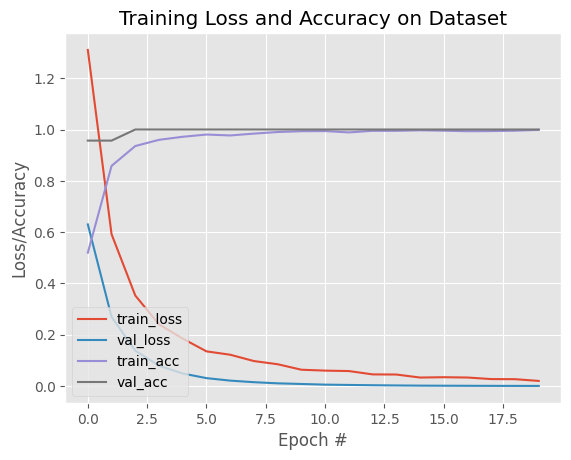

In [ ]:
# Plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

## 🚀📊 Evaluation metrics
✅ Evaluates classification performance visually.

✅ Identifies misclassified samples and confusion between classes.

✅ Helps understand if certain classes are better or worse classified.

In [ ]:

# Predict class probabilities
y_pred_prob = model.predict(X_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)
class_names = ['piriforme', 'sub-cylindrique', 'spheric', 'sub-spheric', 'ovoiide']  # Update with actual class names

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


## Save the model to the deployement ✈

In [ ]:


model.save_weights("model_weights.h5")
model.load_weights("model_weights.h5")


# ✅ Conclusion & Next Steps  

We have successfully trained and evaluated our **Date Fruit Shape Recognition Model** using **DenseNet121** with transfer learning.  
We also visualized the training process and validated our model's performance with a **confusion matrix**.  

📂 **Saved Model Files:**  
- 🗂️ **Model Weights:** `model_weights.h5`  
- 📜 **Full Model (if needed):** `finalized_model.pkl`  

🔖 **Citations & References:**   
- 🔍 For more details, refer to the **official TensorFlow documentation** 📚  

---

### 🚀 Next Steps: **Deploying the Model for Real-World Testing**  

Now that our model is trained, we will move forward to the next crucial step:  
📌 **Deploying and testing the model in a real environment!**  

Stay tuned for the next section where we explore **how to integrate and test the model in real-world scenarios.** 🏗️  


## The First Interface

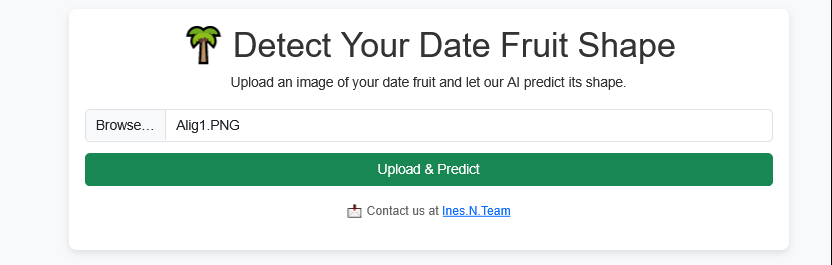

### The Second Interface

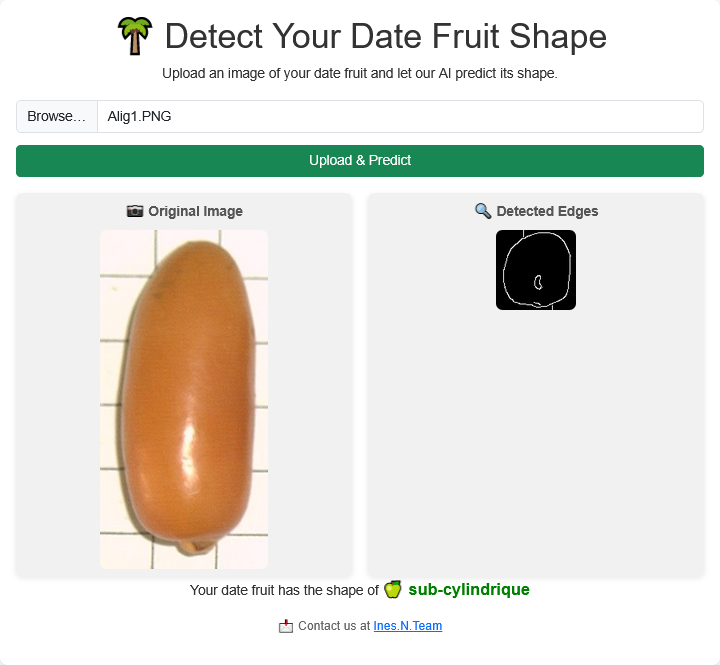